In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

%matplotlib inline

In [2]:
from person import Person
from externalities import Categorical, Offer

In [3]:
Offer.print_help()

timestamp: int between 0 and 999999999
valid_from: int between 0 and 999999999
valid_to: int between 0 and 999999999
difficulty: positive numeric
reward: positive numeric
channel: Categorical(['web' 'email' 'mobile' 'social'])
type: Categorical(['bogo' 'discount' 'informational'])


In [4]:
offer_channel = Categorical(('web', 'email', 'mobile', 'social'), (1, 1, 1, 1))
offer_type = Categorical(('bogo', 'discount', 'informational'), (0, 1, 0))

discount = Offer(0, valid_from=10, valid_until=20, difficulty=10, reward=2, channel=offer_channel, type=offer_type)

In [5]:
print 'Categorical([{}])'.format(','.join(map(lambda s: "'" + s + "'", offer_type.names)))

Categorical(['bogo','discount','informational'])


In [6]:
Person.print_help()

id: uuid.uuid4() (set automatically)
dob: 'YYYYMMDD'
gender: ['M', 'F', 'O']
became_member_on: 'YYYYMMDD'
income: positive numeric
taste: Categorical(['sweet','sour','salty','bitter','umami'])
marketing_segment: Categorical(['front page','local','entertainment','sports','opinion','comics'])

last_transaction: Transaction
last_unviewed_offer: Offer
last_viewed_offer: Offer
history: list of Offers and Transactions sorted by Event timestamps

view_offer_sensitivity: Categorical(['background','offer_age','web','email','mobile','social'])
make_purchase_sensitivity: Categorical(['background','time_since_last_transaction','time_since_last_viewed_offer','viewed_active_offer','web','email','mobile','social'])
purchase_amount_sensitivity: Categorical(['background','income_adjusted_purchase_sensitivity','front page','local','entertainment','sports','opinion','comics','sweet','sour','salty','bitter','umami'])


In [7]:
person_taste = Categorical(['sweet','sour','salty','bitter','umami'],
                           [1,1,0,0,0])

person_marketing_segment = Categorical(['front page','local','entertainment','sports','opinion','comics'],
                                       [1, 1, 0, 0, 0, 1])

person_view_offer_sensitivity = Categorical(['background', 'offer_age','web','email','mobile', 'social'],
                                            [0, -1, 1, 1, 1, 1])

person_make_purchase_sensitivity = Categorical(['background', 'time_since_last_transaction','time_since_last_viewed_offer','viewed_active_offer','web','email','mobile'])
person_purchase_amount_sensitivity = Categorical(['background','income_adjusted_purchase_sensitivity','front page','local','entertainment','sports','opinion','comics','sweet','sour','salty','bitter','umami'])

person = Person(became_member_on='20170716', view_offer_sensitivity=person_view_offer_sensitivity)
person.last_unviewed_offer = discount

In [8]:
discount.__dict__

{'difficulty': 10,
 'reward': 2,
 'timestamp': 0,
 'valid_from': 10,
 'valid_until': 20}

In [9]:
person.__dict__

{'became_member_on': '20170716',
 'dob': '19010101',
 'gender': None,
 'history': [],
 'id': UUID('f419e969-ab45-4b19-b1e5-25e5a0171c3f'),
 'income': None,
 'last_transaction': None,
 'last_unviewed_offer': <externalities.Offer at 0x9721978>,
 'last_viewed_offer': None,
 'make_purchase_sensitivity': <externalities.Categorical at 0x97af860>,
 'marketing_segment': <externalities.Categorical at 0x97af7b8>,
 'purchase_amount_sensitivity': <externalities.Categorical at 0x97af908>,
 'taste': <externalities.Categorical at 0x3a695f8>,
 'view_offer_sensitivity': <externalities.Categorical at 0x97af6a0>}

In [10]:
person.view_offer(0)

In [11]:
person.__dict__

{'became_member_on': '20170716',
 'dob': '19010101',
 'gender': None,
 'history': [],
 'id': UUID('f419e969-ab45-4b19-b1e5-25e5a0171c3f'),
 'income': None,
 'last_transaction': None,
 'last_unviewed_offer': None,
 'last_viewed_offer': <externalities.Offer at 0x9721978>,
 'make_purchase_sensitivity': <externalities.Categorical at 0x97af860>,
 'marketing_segment': <externalities.Categorical at 0x97af7b8>,
 'purchase_amount_sensitivity': <externalities.Categorical at 0x97af908>,
 'taste': <externalities.Categorical at 0x3a695f8>,
 'view_offer_sensitivity': <externalities.Categorical at 0x97af6a0>}

In [12]:
def g(x):
    return 1.0/(1.0 + np.exp(-x))

def g_inv(y):
    return np.log(y/(1.0-y))

In [13]:
# 1 tick = 1 hour
# likelihood of viewing an offer right away is 
# an offer is forgotten after 1 month = 1 * 24 * 30 ticks

# some state values are static and some are dynamic
# dynamic: offer_age
#
# static: channels (and all set equal to 1 for convenience)
# background sensitivity is the sum of the sensitivities of the static state variables
# a zero or negative sensitivity is relative - if all sensitivities are set to  0, then the background level is 50%
# if two are +1 and two are -1, then there is a greater reaction when only the positive channels are present 


# if a channel has negative sensitivity and it is present, then a person is less likely to view: this seems unrealistic
# if a channel has zero sensitivity and it is present, then a person is equally likely to view: seems realistic
# if a channel has positive sensitivity and it is present, then a person is more likely to view: seems realistic
# therefore we need a background level, otherwise it's 50% or greater by default

person_view_offer_sensitivity = Categorical(['background', 'offer_age','web','email','mobile', 'social'],
                                            [g_inv(0.20) - 4, -1, 0, 1, 1, 2])
person = Person(became_member_on='20170716', view_offer_sensitivity=person_view_offer_sensitivity)

history = list()
for i in range(10000):
    person.last_unviewed_offer = discount
    if person.view_offer(0) is not None:
        # print i, 'Viewed'
        history.append(1)
    else:
        # print i, 'Not viewed'
        history.append(0)
        
np.mean(history)

0.19589999999999999

In [14]:
g_inv(0.01)/float(1*24*30)

-0.0063821109029647081

In [15]:
# 1 tick = 1 hour
# likelihood of viewing an offer right away is 
# an offer is forgotten after 1 month = 1 * 24 * 30 ticks

# some state values are static and some are dynamic
# dynamic: offer_age
#
# static: channels (and all set equal to 1 for convenience)
# background sensitivity is the sum of the sensitivities of the static state variables
# a zero or negative sensitivity is relative - if all sensitivities are set to  0, then the background level is 50%
# if two are +1 and two are -1, then there is a greater reaction when only the positive channels are present 


# if a channel has negative sensitivity and it is present, then a person is less likely to view: this seems unrealistic
# if a channel has zero sensitivity and it is present, then a person is equally likely to view: seems realistic
# if a channel has positive sensitivity and it is present, then a person is more likely to view: seems realistic
# therefore we need a background level, otherwise it's 50% or greater by default

person_view_offer_sensitivity = Categorical(['background', 
                                             'offer_age',
                                             'web','email','mobile', 'social'],
                                            [g_inv(0.20) - 4, 
                                             g_inv(0.01)/float(1*24*30), 
                                             0, 1, 1, 2])
person = Person(became_member_on='20170716', view_offer_sensitivity=person_view_offer_sensitivity)

n_trials = 100
n_ticks = 500

histories = list()
for trial in range(n_trials):
    history = list()
    for i in range(n_ticks):
        person.last_unviewed_offer = discount
        if person.view_offer(i) is not None:
            # print i, 'Viewed'
            history.append(1)
        else:
            # print i, 'Not viewed'
            history.append(0)
    histories.append(history)
    
mean_history = list()
for i in range(n_ticks):
    mean_history.append(np.mean([histories[trial][i] for trial in range(n_trials)]))
    

In [16]:
g(g_inv(0.90) - 0 - 1 - 1 - 2 + 0 + 1 + 1 + 0)

0.54914693962071626

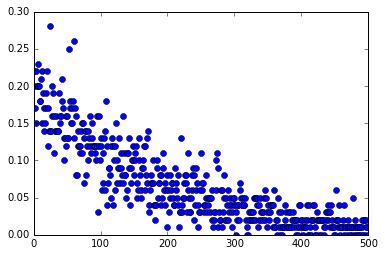

In [17]:
plt.plot(range(n_ticks), mean_history, 'o')

In [18]:
g_inv(0.01)/float(1*24*30)

-0.0063821109029647081